# CS345 Project

## Team Members
1. Hamad Alyami
2. Benito Encarnacion

## Dataset
Our dataset was from Kaggle by a user called Mexwell. The data is paragraphs scraped from wikipedia in 2018 in 235 languages.

The dataset contains 235,000 datasets with balance between language proportions and a test and train split provided.

The downloaded folder from Kaggle contains:
- labels.csv: A file containing the language name, 2-3 letter code, German name, and language family of all the languages present in the dataset.
- README.txt: A file explaining the folder contents.
- urls.txt: A file containing the urls of where the paragraphs were found.
- x_test.txt: The testing data samples, paragraphs in multiple languages.
- x_train.txt: The training data samples, paragraphs in multiple langauges
- y_test.txt: The labels for the testing dataset, using the 2-3 letter codes found in labels.csv.
- y_train.txt: The labels for the training dataset, using the 2-3 letter codes found in labels.csv


## Project
Our project is to train and compare two ML models on the Latin Alphabet languages present in the dataset and compare their performance.

## Motivation
We decided to do this project because it allows us to explore practical applications of natural language processing and machine learning by working with real-world multilingual data. Language identification is an important task in many systems and applications like search engines, translation tools, and content moderation. Working with such a dataset gives us the opportunity to apply classification techniques in a meaningful way. By focusing on languages that use the Latin alphabet, we avoid complications from different writing systems while still working with a variety of languages.

## Models
The models we decided to work with in this project are:
- Multinomial Naive-Bayes (MNB): Uses word frequencies in each class, langauges in our case, to guess the most likely class for text it has not seen.

- Feed Forward Neural Network (FNN): An artificial Neural Network where information moves from input to output without looping back. It uses neurons, connected nodes, to learn patterns and make predictions.

### Data Preprocessing
We will begin by reading the data from the files then:
1. Remove Null Values
2. Filter to keep texts of languages we want using the 2-3 letter codes
3. Return both samples from x_test and x_train and labels from y_test and y_train stacked into X and y

In [1]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import accuracy_score

#Understanding the data set
import pandas as pd
import numpy as np
            #Italina, French, Spanish, Portugese, English, German, Dutch, Indonesian, Finnish, Hausa
lang_codes = ['ita', 'fra', 'spa', 'eng', 'ind']
langs = ['Italian', 'French', 'Spanish', 'English', 'Indonesian']

def file_to_np_array(path, label):
    try:
        df = pd.read_csv(path, sep='<NonExistenceSeparator>', header=None, engine='python')
        print(f"{label}: Read!")
    except Exception as e:
        print(f"Error reading the {label} file: {e}")
        return None
    return df.to_numpy()


def clean_np_data(X, y):
    stacked = np.hstack((y, X)) # Stack y and X side by side
    # print(stacked.shape)
    clean_stacked = stacked[~np.any(pd.isna(stacked), axis=1), :] # Remove empty values
    # print(clean_stacked.shape)
    true_clean = clean_stacked[np.isin(clean_stacked[:,0], lang_codes),:] # Remove all rows that aren't our target languages
    # print(true_clean.shape)
    return true_clean[:,1], true_clean[:,0] # Return cleaned as X and y split again

def clean_filter_and_stack(X_train_file, y_train_file, X_test_file, y_test_file):
    X_train_clean, y_train_clean = clean_np_data(file_to_np_array(X_train_file, X_train_file), 
                                       file_to_np_array(y_train_file, y_train_file))
    X_test_clean, y_test_clean = clean_np_data(file_to_np_array(X_test_file, X_test_file), 
                                       file_to_np_array(y_test_file, y_test_file))
    return np.hstack((X_train_clean, X_test_clean)).astype(str), np.hstack((y_train_clean, y_test_clean)).astype(str)

X, y = clean_filter_and_stack("Data/x_train.txt", 
                                      "Data/y_train.txt", 
                                      "Data/x_test.txt", 
                                      "Data/y_test.txt")

print(X.shape, y.shape)

Data/x_train.txt: Read!
Data/y_train.txt: Read!
Data/x_test.txt: Read!
Data/y_test.txt: Read!
(5000,) (5000,)


#### Data Discovery
This code is to find what is the sample distribution between languages and average word count of each sample of each language.

In [2]:
def avg_words(filtered_X):
    total = 0
    for text in filtered_X:
        words = str(text).split()
        total += len(words)

    return total / len(filtered_X)

def word_count_perlang(X, y):
    avg_word_count = []
    for lang in lang_codes:
        filtered_X = X[y == lang]
        avg_word_count.append(avg_words(filtered_X))
    
    return avg_word_count

def lang_perc(y):
    lang_perc = []
    total = len(y)
    for lang in lang_codes:
        count = (y == lang).sum()
        percent = (count / total) * 100
        lang_perc.append(percent)
    return lang_perc

df = pd.DataFrame({
    'Language': langs,
    'Percent of Dataset (%)': lang_perc(y),
    'Average Word Count': word_count_perlang(X, y)
})

display(df)

# from sklearn.naive_bayes import MultinomialNB

# model = MultinomialNB()
# model.fit(X_train_vectors, y_train)
# print("Done training MNB")

# y_pred = model.predict(X_test_vectors)
# accuracy = accuracy_score(y_test, y_pred)
# print("Overall accuracy of MNB: " + str(accuracy * 100) + "%")



,Language,Percent of Dataset (%),Average Word Count
0,Italian,20.0,68.192
1,French,20.0,67.707
2,Spanish,20.0,67.295
3,English,20.0,70.455
4,Indonesian,20.0,57.147


#### Data Split
Here we use Sklearn train_test_split to split our data into 70/30 train and test splits, respectively, after shuffling them randomly.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3500,) (3500,)
(1500,) (1500,)


And then vectorize our dataset for the MNB.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(strip_accents='unicode')
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
print("Done vectorizing")

Done vectorizing


We train our MNB using the MultinomialNB() function from sklearn on X_train which is 70% of our dataset.

### MNB
The sklearn MNB implementation has two main hyperparameters, alpha and fit_prior.

- alpha is used to smooth the data, so the model doesn’t get confused if a word doesn’t appear in some languages. This helps prevent errors, especially when some words are rare. The default value alpha=1.0 usually works well for text data like ours.

- fit_prior decides whether the model should learn how common each language is from the training data. Since all our language samples are balanced (equal amounts), the default setting (True) works fine.

So, for our language detection project, we don’t need to change these settings — the defaults are already a good fit.

In [5]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vectors, y_train)
print("Done training MNB")

from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy of MNB: " + str(accuracy * 100) + "%")

Done training MNB
Overall accuracy of MNB: 98.93333333333332%


Considering our MNB accuracy is unexpectadly hard, we decided to add 5 more languages; Hausa, Portugese, Finnish, German, and Dutch. This is to introduce more languages that are similar like German and Dutch and Spanish and Portugese but at the same time some that are different like Hausa from all the others.

In [6]:
lang_codes = ['ita', 'fra', 'spa', 'por', 'eng', 'deu', 'nld', 'ind', 'fin', 'hau']
langs = ['Italian', 'French', 'Spanish', 'Portuguese', 'English', 'German', 'Dutch', 'Indonesian', 'Finnish', 'Hausa']

In [7]:
X, y = clean_filter_and_stack("Data/x_train.txt", 
                                      "Data/y_train.txt", 
                                      "Data/x_test.txt", 
                                      "Data/y_test.txt")

df = pd.DataFrame({
    'Language': langs,
    'Percent of Dataset (%)': lang_perc(y),
    'Average Word Count': word_count_perlang(X, y)
})

display(df)

Data/x_train.txt: Read!
Data/y_train.txt: Read!
Data/x_test.txt: Read!
Data/y_test.txt: Read!


,Language,Percent of Dataset (%),Average Word Count
0,Italian,10.0,68.192
1,French,10.0,67.707
2,Spanish,10.0,67.295
3,Portuguese,10.0,66.184
4,English,10.0,70.455
5,German,10.0,59.762
6,Dutch,10.0,55.657
7,Indonesian,10.0,57.147
8,Finnish,10.0,48.431
9,Hausa,10.0,75.802


We can still see that the data is still equally distributed, with each language being 10% of the data set. We do see a discrepency however in the average word count of the samples for each langugae, with overall average being around 65. We see that Finnish has an average of 48 words, the lowest, and Haussa has the highest.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

vectorizer = CountVectorizer(strip_accents='unicode')
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
print("Done vectorizing")

model = MultinomialNB()
model.fit(X_train_vectors, y_train)
print("Done training MNB")

y_pred = model.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy of MNB: " + str(accuracy * 100) + "%")

(7000,) (7000,)
(3000,) (3000,)
Done vectorizing
Done training MNB
Overall accuracy of MNB: 98.1%


The overall accuracy is still really good, much more than what we anticipated or expected.

In [9]:
def get_lang_accuracies(y_true, y_pred):
    df = pd.DataFrame({'language': y_true, 'pred': y_pred})
    accuracies = []

    for lang in lang_codes:
        lang_group = df[df['language'] == lang]
        if len(lang_group) > 0:
            acc = accuracy_score(lang_group['language'], lang_group['pred'])
        else:
            acc = 0
        accuracies.append(acc)
    
    percent_accuracies = [x * 100 for x in accuracies]
    df = None
    return percent_accuracies

df_MNB_lang = pd.DataFrame({
    'Language': langs,
    'Accuracy of MNB/language': get_lang_accuracies(y_test, y_pred)
})

display(df_MNB_lang)

,Language,Accuracy of MNB/language
0,Italian,96.855346
1,French,99.335548
2,Spanish,97.647059
3,Portuguese,93.728223
4,English,100.000000
5,German,97.569444
6,Dutch,98.275862
7,Indonesian,98.615917
8,Finnish,99.315068
9,Hausa,99.662162


#### Accuracy
We see that the over all accuracy is 98.1 which is still very high and didn't expect. More so, we see that English has a 100% accuracy. We would like to also note how Portugese is the lowest withh 93.7% and Finnish is the second best with an almost perfect accuracy of 99.3%.

We will attempt to explore the model more and theorize why we ended up with such results down below.

In [10]:
def top_words_per_lang(model, vectorizer, top_n=5):
    feature_names = vectorizer.get_feature_names_out()
    log_probs = model.feature_log_prob_
    class_indices = {label: i for i, label in enumerate(model.classes_)}
    
    return [
        [feature_names[i] for i in log_probs[class_indices[lang]].argsort()[::-1][:top_n]]
        for lang in lang_codes
    ]

df_top_words_MNB = pd.DataFrame({
    'Language': langs,
    'Top words per lang' :top_words_per_lang(model, vectorizer, 5)
})

pd.set_option('display.max_colwidth', None) 

display(df_top_words_MNB)

,Language,Top words per lang
0,Italian,"[di, il, la, in, del]"
1,French,"[de, la, le, en, et]"
2,Spanish,"[de, la, en, el, que]"
3,Portuguese,"[de, em, do, que, da]"
4,English,"[the, of, in, and, to]"
5,German,"[der, die, und, in, von]"
6,Dutch,"[de, van, in, het, een]"
7,Indonesian,"[yang, dan, di, pada, dari]"
8,Finnish,"[ja, on, oli, han, vuonna]"
9,Hausa,"[da, ta, ya, na, ne]"


We used this function to identify what are the top 5 words that the model, MultinomialNB(), found to be the most indicative of a class. To do this, we used MultinomialNB()'s **feature_log_prob_ variable**, which stores the log-probability of each word (feature) given each class (language). This means it tells us how strongly each word is associated with each language according to the model.

The shape of this variable is **(n_classes, n_features)**, where n_classes is the number of languages and n_features is the number of unique words in the vocabulary. Each row shows the log-probabilities for one class, and each column represents a word. The higher the value, the more important that word is for predicting that class.

We collected the top 5 because it provides a good balance between being explanatory and concise.

In [11]:
def compute_overlap_matrix(top_words_list):
    n = len(lang_codes)
    matrix = []

    for i in range(n):
        row = []
        for j in range(n):
            overlap = len(set(top_words_list[i]).intersection(top_words_list[j]))
            row.append(overlap)
        matrix.append(row)

    return pd.DataFrame(matrix, index=lang_codes, columns=lang_codes)

top_words_list = top_words_per_lang(model, vectorizer, 5)
overlap_df = compute_overlap_matrix(top_words_list)

#### Top Words in all Languages
In the cell below we find the top 5 words that appear in all languages.

In [31]:
def find_shared_words(word_lists):
    word_counts = {}
    
    for word_list in word_lists:
        for word in word_list:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    shared = []
    for word, count in word_counts.items():
        if count > 1:
            shared.append(word)

    return shared

shared_words = find_shared_words(top_words_list)
print("Words appearing in more than one language, top 5:", shared_words)

Words appearing in more than one language, top 5: ['di', 'la', 'in', 'de', 'en', 'que', 'da']


#### Heat-map of Words Correlation between Languages
Here we use a matplot to give a colored heat-map of how many words of our top 5 from each language meet between each language.

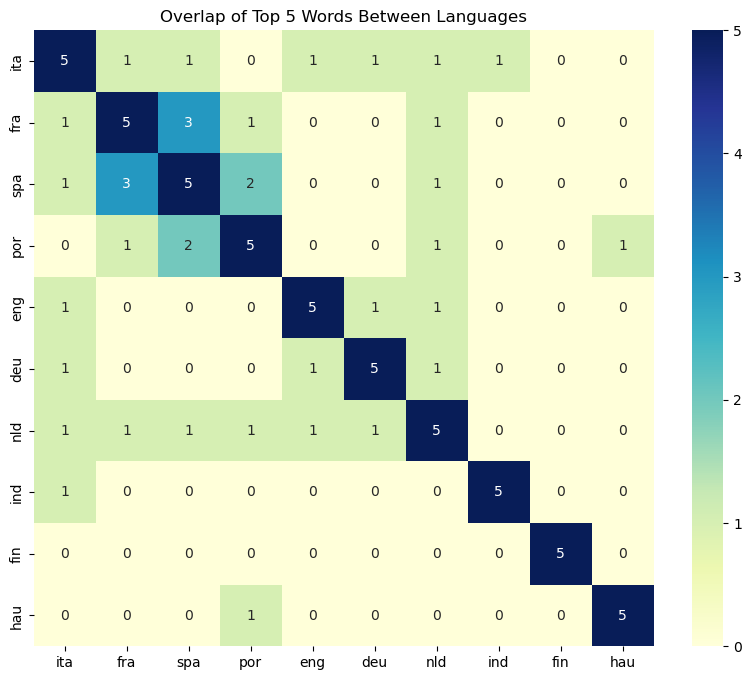

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_df, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Overlap of Top 5 Words Between Languages")
plt.show()

In the heat-map we find without any surprise that between each language and itself a 5. Next French and Spanish meet with 3 words and then Portugese and Spanish.

When focusing on English and Finnish, we see more. Finnish has absolutly no correlation in its top 5 words with any other language while English still has some, 1 word each, with some other languages. This explains why Finnish has such a high accuracy but why not higher than English?

In [ ]:
analyzer = vectorizer.build_analyzer()

def count_top_words_in_lang_samples(X, y, top_words_count):
    results = []
    for i, lang in enumerate(lang_codes):
        lang_samples = X[y == lang]
        word_counts = []

        for word in top_words_list[i]:
            count = sum(word in analyzer(text) for text in lang_samples)
            word_counts.append(count)

        results.append(word_counts)
    return results

def MNB_words_table(top_words, top_words_count):
    for i, lang in enumerate(langs):
        print(lang + ":")
        df = pd.DataFrame({
            "Word": top_words[i],
            "Count in Dataset": top_words_count[i]
        })
        display(df)

top_words = top_words_per_lang(model, vectorizer, 5)
top_counts = count_top_words_in_lang_samples(X, y, top_words)

MNB_words_table(top_words, top_counts)

Italian:


,Word,Count in Dataset
0,di,786
1,il,596
2,la,599
3,in,520
4,del,500


French:


,Word,Count in Dataset
0,de,934
1,la,741
2,le,650
3,en,568
4,et,713


Spanish:


,Word,Count in Dataset
0,de,939
1,la,827
2,en,766
3,el,740
4,que,527


Portuguese:


,Word,Count in Dataset
0,de,875
1,em,542
2,do,558
3,que,488
4,da,560


English:


,Word,Count in Dataset
0,the,913
1,of,790
2,in,760
3,and,814
4,to,580


German:


,Word,Count in Dataset
0,der,760
1,die,587
2,und,712
3,in,581
4,von,465


Dutch:


,Word,Count in Dataset
0,de,892
1,van,806
2,in,742
3,het,694
4,een,707


Indonesian:


,Word,Count in Dataset
0,yang,720
1,dan,747
2,di,546
3,pada,444
4,dari,487


Finnish:


,Word,Count in Dataset
0,ja,781
1,on,477
2,oli,296
3,han,0
4,vuonna,187


Hausa:


,Word,Count in Dataset
0,da,874
1,ta,585
2,ya,473
3,na,582
4,ne,496


Here we see something that would explain things more a bit. We notice that English has a high count overall of the top 5 words in the samples we have. Perhaps not the highest, but the higher ones are found in more than one language, like 'de'. While 'the' is slightly less in count but is only found in English.

This gives a very good idea on why English has the highest accuracy, not only does it have a relatively high count of indicative words by the MNB, but also these words are special and are not found in other languages.

Furhtermore, while Finnish as we saw in the heatmap has no correlation with any other language in our dataset, its top 5 indicative words by the MNB are way less than English, which explains why it performs worse than English even though English has correlation in indicative words with other languages.

### K-Fold
Since our accuracy is high, we will perform k-folds on the dataset using MNB to see how well our model generalizes on unseen data. We choose the optimal number of folds of 5 since it has a balance of testing the model but not being too heavy.

In [15]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

model_kfold = make_pipeline(CountVectorizer(), MultinomialNB())
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=17)

all_preds = []
all_true = []

X_train_kfold = X_train.copy()
X_test_kfold = X_test.copy()
y_train_kfold = y_train.copy()
y_test_kfold = y_test.copy()

k_folds_accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train_kfold, X_test_kfold = X[train_index], X[test_index]
    y_train_kfold, y_test_kfold = y[train_index], y[test_index]

    model_kfold.fit(X_train_kfold.flatten(), y_train_kfold.flatten())
    y_pred_kfold = model_kfold.predict(X_test_kfold.flatten())

    fold_accuracy = accuracy_score(y_test_kfold, y_pred_kfold)
    k_folds_accuracies.append(fold_accuracy)

    all_preds.extend(y_pred_kfold)
    all_true.extend(y_test_kfold)

In [16]:
df_kfold_accuracy = pd.DataFrame({
    'Kfold': [1, 2, 3, 4, 5],
    'Accuracy': k_folds_accuracies
})


print("Cross-Validation Results (Accuracy):")

display(df_kfold_accuracy)

print(f'\nOverall Kfolds Mean Accuracy: {cross_val_score(model_kfold, X.flatten(), y.flatten(), cv=kf).mean() * 100:}%')

def get_lang_accuracies(y_true, y_pred):
    df = pd.DataFrame({'language': y_true, 'pred': y_pred})
    accuracies = []

    for lang in lang_codes:
        lang_group = df[df['language'] == lang]
        if len(lang_group) > 0:
            acc = accuracy_score(lang_group['language'], lang_group['pred'])
        else:
            acc = 0
        accuracies.append(acc)

    return accuracies

df_lang_accuracy = pd.DataFrame({
    'Language': langs,
    'Accuracy of MNB/language': get_lang_accuracies(np.array(all_true), np.array(all_preds))
})

display(df_lang_accuracy)

Cross-Validation Results (Accuracy):


,Kfold,Accuracy
0,1,0.9825
1,2,0.9830
2,3,0.9825
3,4,0.9860
4,5,0.9840



Overall Kfolds Mean Accuracy: 98.36%


,Language,Accuracy of MNB/language
0,Italian,0.985
1,French,0.993
2,Spanish,0.980
3,Portuguese,0.949
4,English,0.998
5,German,0.982
6,Dutch,0.980
7,Indonesian,0.978
8,Finnish,0.996
9,Hausa,0.995


We see from the results from the K-folds that the accuracy is still consistent which indicates to use that the model is quite robust. The accuracies are also consistent for the languages.

Due to these results we will assume that the top 5 words indicative for MNB will be similar to what we found previously.

#### 

### MNB Conclusions
While we haven't anticipated this high of an accuracy for our MNB, intuitively it makes sense. There are certain words that are only found in certain languages and they appear quite often in most sentences, like articles in English. And while some other languages have correlation when it comes to the indicative words their count and combination with other unique words in the language makes it possible for the MNB to classify the language accuratly.

Thus, MNB performs quite well when given decently sized texts from languages to train on, like paragraphs. This gives it the ability to record the most common words in that language and the unique words that exist in the language.

When testing, if given a valid sentence, it will be able to accuratly classify it sense for example, a simple sentence in English no matter how short will contain articles, verbs, or adjectives.



In [17]:
X_test_addtl = np.array([
    # Italian
    "Bambini ridevano mentre guardavano fuochi sopra ponte vecchio.",
    "Neve fresca copriva tetto rustico durante alba tranquilla.",

    # French
    "Clé cassée resta coincée sous meuble ancien.",
    "Lumière faible éclairait couloir désert chaque nuit.",

    # Spanish
    "Guitarra sonaba cerca ventana rota durante fiesta secreta.",
    "Sombras largas cruzaban pasillo viejo sin sonido alguno.",

    # Portuguese
    "Barco afundou devagar próximo cais silencioso.",
    "Fumaça subia após explosão repentina dentro fábrica antiga.",

    # English
    "Impetus convive.",
    # "afjlkasdf",
    "Galvanized Acumen.",

    # German
    "Regen fiel schnell gegen Bäume kahlen draußen.",
    "Kerze flackerte still auf Tisch zerkratzt alt.",

    # Dutch
    "Stilte hing rond toren verlaten zonder mensen.",
    "Kleine boot dreef langzaam over meer breed.",

    # Indonesian
    "Topi merah jatuh ke lantai tanpa suara.",
    "Malam gelap membawa angin kencang lewat bukit.",

    # Finnish
    "Hiljainen järvi heijasti kuun valoa yössä.",
    "Vanha mies kulki polkua pitkin varhain aamulla.",

    # Hausa
    "Gashi nata ya bushe daga iska mai sanyi.",
    "Kwalliya ta fadi kan kasa lokacin dare ya zo."
])

y_test_addtl = np.array(['ita', 'ita', 'fra', 'fra', 'spa', 'spa', 'por', 'por',
                        'eng', 'eng', 'deu', 'deu', 'nld', 'nld', 'ind', 'ind',
                        'fin', 'fin', 'hau', 'hau'])

In [18]:
vectorizer = CountVectorizer(strip_accents='unicode')
X_train_vectors = vectorizer.fit_transform(X_train)  # Fit only on training
X_test_addtl_vect = vectorizer.transform(X_test_addtl)

y_pred_addtl = model.predict(X_test_addtl_vect)
accuracy_addtl = accuracy_score(y_test_addtl, y_pred_addtl)
print("Overall accuracy of MNB: " + str(accuracy_addtl * 100) + "%")

Overall accuracy of MNB: 90.0%


# Feed Forward Neural Network

In [19]:
# Reorganizing data for Feed Forward Neural Network input

# 1) convert string labels into integer labels
#      and make func to convert back


def str_labels_to_int_labels(labelArr, string_labels):
    rtn = np.empty(labelArr.shape, dtype=int)
    for i, v in enumerate(string_labels):
        rtn[labelArr == v] = i
    return rtn

def int_labels_to_str_labels(labelArr, string_labels):
    rtn = np.empty(labelArr.shape, dtype='object')
    for i, v in enumerate(string_labels):
        rtn[labelArr == i] = v
    return rtn

# print(y_test[0:5])
# y1 = str_labels_to_int_labels(y_test, all_str_labels)
# print(y1[0:5])
# y2 = int_labels_to_str_labels(y1, all_str_labels)
# print(y2[0:5])

In [20]:
# 2) convert data into multi-column matrix of characters
#      and make func to convert back

def str_vec_to_float_matrix(strVec, longest_str_len):
    # Pad strings to all be equal length
    padded_strVec = np.char.ljust(strVec, longest_str_len, fillchar=' ')

    # turn vector of strings into matrix of characters
    stacked_char_matrix = np.vstack([np.array(list(s)) for s in padded_strVec])

    # turn char matrix into int matrix
    char_matrix_to_int_matrix = np.vectorize(ord)
    int_matrix = char_matrix_to_int_matrix(stacked_char_matrix)

    #normalize and scale so each value is a float between 0 and 1
    matrix_max = np.max(int_matrix)
    matrix_min = np.min(int_matrix)
    min_subtracted_matrix = int_matrix - matrix_min
    normalized_matrix = (min_subtracted_matrix / (matrix_max - matrix_min))
    return normalized_matrix

# Don't need to convert matrices back into rows of text because the neural network isn't designed to generate anything, just classify
# def int_matrix_to_str_vec(intMatrix):
#     int_matrix_to_char_matrix = np.vectorize(chr)
#     char_matrix = int_matrix_to_char_matrix(intMatrix)
#     padded_strVec = np.array(["".join(r) for r in char_matrix])
#     return np.char.rstrip(padded_strVec)

# print(X_test[0])
# X_x = str_vec_to_int_matrix(X_test.astype(str))
# print(X_x[0])
# X_y = int_matrix_to_str_vec(X_x)
# print(X_y[0])

In [21]:
# 3) use them both

def convert_to_FFNN_format(Xr, Xe, yr, ye):
    max_str_len_1 = np.max(np.char.str_len(Xr))
    max_str_len_2 = np.max(np.char.str_len(Xe))
    max_str_len = max(max_str_len_1, max_str_len_2)
    Xr_rtn = str_vec_to_float_matrix(Xr, max_str_len)
    Xe_rtn = str_vec_to_float_matrix(Xe, max_str_len)
    return (Xr_rtn, 
            Xe_rtn,
            str_labels_to_int_labels(yr, lang_codes), 
            str_labels_to_int_labels(ye, lang_codes))

(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn) = convert_to_FFNN_format(X_train, X_test, y_train, y_test)

print("Done converting data into FFNN format")

Done converting data into FFNN format


In [22]:
# print(X_tr_nn[0])
# print(X_tr_nn[1])
print(X_tr_nn.shape)
print(X_te_nn.shape)

(7000, 5577)
(3000, 5577)


In [23]:
# Applying properly structured data to a basic FFNN

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

print("Done importing Tensorflow Stuff")

2025-05-08 18:12:57.147556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done importing Tensorflow Stuff


In [24]:
# Make FFNN

sample_length = X_tr_nn[0].shape[0]

FFNN_model = Sequential([
    Input((sample_length,)),
    Dense(1024, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

FFNN_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(), 
                   metrics=[SparseCategoricalAccuracy()])

In [25]:

for i in range(51):
    FFNN_model.fit(X_tr_nn, y_tr_nn)
    if (i%5 == 0):
        print("\n", i, ": ")
        test_loss, test_acc = FFNN_model.evaluate(X_te_nn, y_te_nn)
        print(f'\nTest accuracy: {test_acc}', "\n")

219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.0978

 0 : 
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3029 - sparse_categorical_accuracy: 0.1021

Test accuracy: 0.0976666659116745 

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 2.3000 - sparse_categorical_accuracy: 0.1114
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 2.2829 - sparse_categorical_accuracy: 0.1372
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 2.2551 - sparse_categorical_accuracy: 0.1556
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 2.2272 - sparse_categorical_accuracy: 0.1620
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 2.1808 - sparse_categorical_accuracy: 0.1859

 5 : 
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9094 - sparse_categorical_accuracy: 0.1056

Test accuracy: 0.09966666996479034 

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 2.1611 - sparse_categorical_accuracy: 0.1991
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 2.1110 - spa

The accuracy of this result is unexpectedly low. An accuracy of around 10% given that there are 10 labels implies that the model isn't making any accurate predictions at all. 
There are a few things we decided to try to boost its accuracy. First we decided to change how we normalized the data. The way the data is currently normalized converts each string into a row of characters, each character into an integer, and each integer into a floating point number between 0 and 1, based on the highest and lowest integer value for all the characters. This creates an uneven distribution of floating point numbers between 0 and 1, with most characters being represented as very low floaing point numbers (e.g. less than 0.01) and some being quite high (e.g. about 0.6). This is because most characters are simply the ascii values of the latin alphabet, which ranges from about 0 to 200, whereas some special characters are represented by numbers in the thousands when considering unicode.

To get around this uneven distribution, we will assign each character its own unique integer value, and divide by the total number of unique characters in all sets.

In [26]:
def str_vec_to_char_matrix(strVec, longest_str_len):
    # Pad strings to all be equal length
    padded_strVec = np.char.ljust(strVec, longest_str_len, fillchar=' ')

    # turn vector of strings into matrix of characters
    stacked_char_matrix = np.vstack([np.array(list(s)) for s in padded_strVec])
    return stacked_char_matrix

# This func takes a vector of strings and returns a vector of unique characters found in those string
def alph_from_str_vec(strVec):
    l = list(strVec)
    bigString = "".join(l)
    setOfChars = set(bigString)
    return np.array(sorted(list(setOfChars)))

# I tried without dictionaries before and it was way too slow
def map_char_to_value(c_key, alph_dict):
    return alph_dict[c_key]

def str_vec_to_float_matrix__even_distribution(strVec, longest_str_len, alph_dict):
    char_matrix =  str_vec_to_char_matrix(strVec, longest_str_len)

    def map_char_to_value_vectorizable(c):
        return map_char_to_value(c, alph_dict)
        
    map_chars_vectorized = np.vectorize(map_char_to_value_vectorizable)
    rtn = map_chars_vectorized(char_matrix)

    return rtn

In [27]:
def convert_to_FFNN_format__even_distribution(Xr, Xe, yr, ye):
    # Creating the right alphabet dictionary for data organization
    alph_tr = set(alph_from_str_vec(Xr))
    alph_te = set(alph_from_str_vec(Xe))
    alph = np.array(sorted(list(alph_tr.union(alph_te))))
    alphVals = np.arange(alph.shape[0]) / alph.shape[0]
    alph_dict = {char: val for char, val in zip(alph, alphVals)}

    # Max str len
    max_str_len_1 = np.max(np.char.str_len(Xr))
    max_str_len_2 = np.max(np.char.str_len(Xe))
    max_str_len = max(max_str_len_1, max_str_len_2)

    
    Xr_rtn = str_vec_to_float_matrix__even_distribution(Xr, max_str_len, alph_dict)
    Xe_rtn = str_vec_to_float_matrix__even_distribution(Xe, max_str_len, alph_dict)
    return (Xr_rtn, 
            Xe_rtn,
            str_labels_to_int_labels(yr, lang_codes), 
            str_labels_to_int_labels(ye, lang_codes))

(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn) = convert_to_FFNN_format__even_distribution(X_train, X_test, y_train, y_test)

In [28]:
# Re-compile same model

sample_length = X_tr_nn[0].shape[0]

FFNN_model = Sequential([
    Input((sample_length,)),
    Dense(1024, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

FFNN_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(), 
                   metrics=[SparseCategoricalAccuracy()])

In [29]:
# Test same model

for i in range(51):
    FFNN_model.fit(X_tr_nn, y_tr_nn)
    if (i%5 == 0):
        print("\n", i, ": ")
        test_loss, test_acc = FFNN_model.evaluate(X_te_nn, y_te_nn)
        print(f'\nTest accuracy: {test_acc}', "\n")
    
    

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 2.3085 - sparse_categorical_accuracy: 0.1052

 0 : 
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3052 - sparse_categorical_accuracy: 0.1172

Test accuracy: 0.11833333224058151 

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 2.2929 - sparse_categorical_accuracy: 0.1235
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 2.2913 - sparse_categorical_accuracy: 0.1207
146/219 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.2750 - sparse_categorical_accuracy: 0.1403

KeyboardInterrupt: 

This change did result in a visible improvement, but it still isn't very good, and it required quite a few epochs to improve.

In [ ]:
# also testing the data with only 5 languages again
lang_codes = ['ita', 'fra', 'spa', 'eng', 'ind']
langs = ['Italian', 'French', 'Spanish', 'English', 'Indonesian']


X, y = clean_filter_and_stack("Data/x_train.txt", 
                                      "Data/y_train.txt", 
                                      "Data/x_test.txt", 
                                      "Data/y_test.txt")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn) = convert_to_FFNN_format__even_distribution(X_train, X_test, y_train, y_test)

Data/x_train.txt: Read!
Data/y_train.txt: Read!
Data/x_test.txt: Read!
Data/y_test.txt: Read!


In [ ]:
# Re-compile same model

sample_length = X_tr_nn[0].shape[0]

FFNN_model = Sequential([
    Input((sample_length,)),
    Dense(1024, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

FFNN_model.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(), 
                   metrics=[SparseCategoricalAccuracy()])

In [ ]:
# Test same model

for i in range(51):
    FFNN_model.fit(X_tr_nn, y_tr_nn)
    if (i%5 == 0):
        print("\n", i, ": ")
        test_loss, test_acc = FFNN_model.evaluate(X_te_nn, y_te_nn)
        print(f'\nTest accuracy: {test_acc}', "\n")
    

110/110 [==============================] - 2s 13ms/step - loss: 1.6749 - sparse_categorical_accuracy: 0.2191

 0 : 
47/47 [==============================] - 0s 4ms/step - loss: 1.6733 - sparse_categorical_accuracy: 0.2340

Test accuracy: 0.23399999737739563 

110/110 [==============================] - 1s 13ms/step - loss: 1.4172 - sparse_categorical_accuracy: 0.4037

 5 : 
47/47 [==============================] - 0s 8ms/step - loss: 1.6647 - sparse_categorical_accuracy: 0.2567

Test accuracy: 0.2566666603088379 

110/110 [==============================] - 1s 13ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.5283

 10 : 
47/47 [==============================] - 0s 7ms/step - loss: 1.8804 - sparse_categorical_accuracy: 0.2693

Test accuracy: 0.2693333327770233 

110/110 [==============================] - 2s 15ms/step - loss: 0.9738 - sparse_categorical_accuracy: 0.6237

 15 : 
47/47 [==============================] - 0s 9ms/step - loss: 2.1114 - sparse_categorical_accuracy: 0.278

In [ ]:
lang_codes = ['ita', 'fra', 'spa', 'por', 'eng', 'deu', 'nld', 'ind', 'fin', 'hau']
langs = ['Italian', 'French', 'Spanish', 'Portuguese', 'English', 'German', 'Dutch', 'Indonesian', 'Finnish', 'Hausa']

X, y = clean_filter_and_stack("Data/x_train.txt", 
                                      "Data/y_train.txt", 
                                      "Data/x_test.txt", 
                                      "Data/y_test.txt")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

(X_tr_nn, X_te_nn, y_tr_nn, y_te_nn) = convert_to_FFNN_format__even_distribution(X_train, X_test, y_train, y_test)